# Mine False Positive Samples

Mine false positive data to augment the dataset.

## Select The Region of Interest

Select the region where the false positives appear on the video. False positives appear to be where there is shadow or trees on the left side of the lane. Since no relevant cars appear on this region (only the cars from the opposite direction will be visible), any detection will be false positive and collecting all of them will help augmenting the class of non-vehicles in the dataset.

In [1]:
import glob
import pickle
import numpy as np
import timeit
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog

### Calibration functions

In [2]:
# calibration function
# camera matrix (c_mtx) and distortion coefficients (dist) were
# computed previously.
c_mtx = np.array([
    [1.15396091e+03, 0.00000000e+00, 6.69706056e+02],
    [0.00000000e+00, 1.14802495e+03, 3.85655654e+02],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[
    -2.41016964e-01,
    -5.30788794e-02,
    -1.15812035e-03,
    -1.28281652e-04,
    2.67259026e-02]])
def undistort(raw, c_mtx=c_mtx, dist=dist):
    """Undistort raw camera images.
    
    This function uses the camera matrix (c_mtx), distortion
    coefficients (dist) to undistort raw camera images.
    
    Returns RGB images!
    
    Args:
        raw (ndarray): The image taken by the cameraof which no 
            distortion correction applied. Image should be in `RGB` 
            format, read with `matplotlib.image.imread`.
            
        c_mtx: Camera calibration matrix, can be obtained using the
            `cv2.calibrateCamera` module.
        
        dist: Distortion coefficients, can be obtained using the
            `cv2.calibrateCamera` module.
    """
    
    # get undistorted destination image
    undist = cv2.undistort(raw, c_mtx, dist, None, c_mtx)
    
    return undist

### Define the region of interest

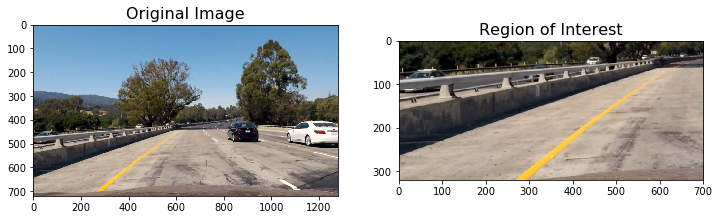

In [3]:
# display a test image to define a general region of interest
test1 = mpimg.imread('./test_images/test1.jpg')

undist_test1 = undistort(test1)

# define the region
x1 = 0
x2 = 700
y1 = 380
y2 = 700

region_of_int = undist_test1[y1:y2, x1:x2]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(undist_test1)
plt.title('Original Image', fontsize=16)
plt.subplot(122)
plt.imshow(region_of_int)
plt.title('Region of Interest', fontsize=16)
plt.show()
plt.close()

### Load the model and the scaler

In [4]:
# Load Classifier
clf_path = './clfs/clf-c-10-kernel-rbf-gamma-auto-pix-16-16-cell-2-2-histeq-1.pkl'
with open(clf_path, mode='rb') as f:
    clf = pickle.load(f)
    print('clf loaded.')
# load X scaler
scaler_path = './datasets/rgb/X-scaler-dataset-pix-16-16-cell-2-2-histeq-1.pkl'
with open(scaler_path, mode='rb') as f:
    X_scaler = pickle.load(f)
    print('X scaler loaded.')

clf loaded.
X scaler loaded.


### Helper functions

In [5]:
# define a function to get hog feature
def get_hog(img, pix_per_cell=(8,8),
    cell_per_block=(2,2), orient=9,
    output_img=False, feature_vector=True):
    """Get HOG feature as flat array.
    
    Returns features as flattened array and the hog image.
    
    Args:
        pix_per_cell(tuple): 2-tuple, specifies the cell size over which each 
            gradient histogram is computed.
        cells_per_block(tuple): 2-tuple, specifies the local area over which 
            the histogram counts in a given cell will be normalized. 
        orient(int): Represents the number of orientation bins.
        output_img(bool): If `False` hog image will not be returned.
    """
    
    if output_img:
        features, hog_image = hog(
            img, orientations=orient, 
            pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,
            visualise=True, feature_vector=feature_vector, block_norm='L2-Hys')
        
        return features, hog_image
    else:
        features = hog(
            img, orientations=orient, 
            pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,
            visualise=False, feature_vector=feature_vector, block_norm='L2-Hys')
        
        return features


# Define a single function that can extract features using hog
# sub-sampling and make predictions
def find_false_positives(
    img, ystart, ystop, scale, svc,
    X_scaler, orient, pix_per_cell, cell_per_block, heatmap=None):
    
    def convert2uin8(img):
        return np.uint8(255 * img / np.max(img))
    
    # if not, convert to unint8
    if img.dtype != np.dtype(np.uint8):
        img = convert2uin8(img)
        
    img1 = cv2.equalizeHist(img[:,:,0])
    img2 = cv2.equalizeHist(img[:,:,1])
    img3 = cv2.equalizeHist(img[:,:,2])
    hist_eq = np.dstack((img1, img2, img3))
    #img = img.astype(np.float32)/255
    
    region_tosearch = hist_eq[ystart:ystop,:,:]
    if scale != 1:
        imshape = region_tosearch.shape
        region_tosearch = cv2.resize(
            region_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = region_tosearch[:,:,0]
    ch2 = region_tosearch[:,:,1]
    ch3 = region_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # 7
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 4 cells and 16 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1 # 3
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog(
        ch1, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), orient,
        output_img=False, feature_vector=False)
    hog2 = get_hog(
        ch2, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), orient,
        output_img=False, feature_vector=False)
    hog3 = get_hog(
        ch3, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), orient,
        output_img=False, feature_vector=False)
    
    false_neg_img = None
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # extract HOG for this patch
            hog_feat1 = hog1[
                ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[
                ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[
                ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                y1 = ytop_draw+ystart
                y2 = ytop_draw+win_draw+ystart
                x1 = xbox_left
                x2 = xbox_left+win_draw
                false_neg_img = img[y1:y2,x1:x2,:]
                # resize to 64 x 64 pixels
                false_neg_img = cv2.resize(false_neg_img, (64,64))
                
    return false_neg_img

In [6]:
# define an empty list for false positive images
false_neg_imgs = []

In [7]:
def process_image(image):
    # define the region
    x1 = 0
    x2 = 700
    y1 = 380
    y2 = 700
    
    # undisort raw camera image
    undist = undistort(image)
    # get the region of interest
    region_of_int = undist[y1:y2, x1:x2]

    orient = 9
    pix_per_cell = 16
    cell_per_block = 2
    ystart = 0
    ystop = region_of_int.shape[0]
    #scale = 1.8
    scale_list = [1.7]

    for scale in scale_list:
        #print('scale is ' + str(scale))
        false_neg_img = find_false_positives(
            region_of_int, ystart, ystop, scale,
            clf, X_scaler, orient, pix_per_cell, cell_per_block)

        if false_neg_img != None:
            false_neg_imgs.append(false_neg_img)
            #print('False neg len: ' + str(len(false_neg_imgs)))
            
    return undist

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
output = 'delete_this_video.mp4'

clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video delete_this_video.mp4
[MoviePy] Writing video delete_this_video.mp4


100%|█████████▉| 1260/1261 [10:11<00:00,  2.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: delete_this_video.mp4 

CPU times: user 10min 8s, sys: 2.41 s, total: 10min 11s
Wall time: 10min 12s


In [10]:
# save false positives
save_path = './vehicle-detection-data/non-vehicles/false-positives'

if not os.path.exists(save_path):
    os.makedirs(save_path)

print(str(len(false_neg_imgs)) + ' images will be saved.')
for i in range(len(false_neg_imgs)):
    plt.imsave(save_path + '/' + str(i) + '.png', false_neg_imgs[i])

103 images will be saved.


---

The false positives are also augmented, for the implementation please go to [this notebook](./augment-false-positives.ipynb).

---